# DAS test notebook


## Overview


For the reader unfamiliar with the 'DAS' project: The idea is to sample
return echoes in a fiber optic cable. The echoes are due to small imperfections
in the cable that interact with near-infrared laser pulses. The pulses 
are sent two hundred times per second, a sampling rate sufficient to
observe distortions in the cable due to low-frequency acoustic environmental
signals. The resulting data -- sampled pulse echoes -- resemble seismic records
were one to place seismometers 
at two-meter intervals along the sea floor in a line 97 kilometers long.


This notebook concerns accessing and interpreting DAS (Distributed Acoustic Sensor)
data.  It is independent of other notebooks in this repository. The data are initially 
found on an ESS server that mimics the S3 object store interface via the minIO software 
package. 


### Actions tracked here

- get this notebook running in jupyter lab
- `pip install minio`
    - [minio API documentation](https://min.io/docs/minio/linux/developers/python/API.html)
- place credentials in an accessible location that is outside of the repository folder
- using these credentials: instantiate a minio `client`
- list: `buckets = client.list_buckets()`
    - includes source HDF5 bucket `OOI-DAS-HDF5`
- list object_name for objects in this bucket
    - Ten files, contiguous time: 02-NOV-2021, Time 00:00:14, 01:14 etc in one-minute intervals
    - One file: 200 Hz, one minute, 12,000 pulses; 47,500 channels per pulse
    - 'channel axis' corresponds to a single sampled pulse (47,500 channels)
    - 'pulse axis' corresponds to pulse transmission at 200Hz (12,000 pulses)
- downloaded example data file (outside the repository: `../../data/das/fnm.h5`
- open this data file: two methods
    - `ds = xarray.open_dataset(fnm)` > xarray Dataset
    - `ncf = netCDF4.Dataset(fnm)` > netcdf 
        - note use of Linux utility `ncdump`: To select and read metadata
            - Example: `!ncdump -h ./../../data/das/2021-11-02T000014Z.h5`
    - the datafile has an intrinsic heirarchy that can be challenging
        - within the file is a folder structure based on the term `**groups**`
- `tree`
    - a useful utility for looking at folder structure/contents
    - See [datatree](https://github.com/xarray-contrib/datatree)
    
    
### Terms and References

- DVS = Distributed Vibration Sensing, a term commonly used in Hartog 2017.
- Hartog, Arthur H. An introduction to distributed optical fibre sensors. CRC press, 2017. (book)
- William, Shima and Brad's recent paper: Wilcock, William SD, Shima Abadi, and Bradley P. Lipovsky. "Distributed acoustic sensing recordings of low-frequency whale calls and ship noise offshore Central Oregon." JASA Express Letters 3, no. 2 (2023): 026002.


## Data access section

Skip ahead: To **Data analysis start**

In [ ]:
# from minio import Minio
# with open('./../../.minio/k.txt', 'r') as file: keys = file.read().split(' ')
# client = Minio("pnwstore1.ess.washington.edu:9000", keys[0], keys[1], secure=False)

In [ ]:
# from the UW network: buckets = client.list_buckets()

`buckets = client.list_buckets()`

```
 Bucket('OOI-DAS-1-Zarr'), etcetera 1, 2, 3, 4, 5, 10, 50, 100, 500, 1000
 Bucket('OOI-DAS-1-tileDB'), etcetera 1, 2, 3, 4, 5
 Bucket('OOI-DAS-HDF5'),
 Bucket('OOI-DAS-HDF5-Zarr')
 ```

In [ ]:
# uncomment to continue data access
# source = buckets[15]
# type(source)

In [ ]:
# List objects information.
# objects = client.list_objects("OOI-DAS-HDF5")
# for obj in objects:
#     if obj.object_name[0] == '2':
#         print(obj.object_name, obj.size) 

In [ ]:
# objects = client.list_objects("OOI-DAS-HDF5")
# for obj in objects:
#     print(obj.object_name)
#     if obj.object_name[0] == '2':
#         this_object_name = obj.object_name
#         print('getting: ', this_object_name, obj.size)
#         client.fget_object("OOI-DAS-HDF5", this_object_name, "../../data/das/" + this_object_name, request_headers=None, ssec=None, version_id=None, extra_query_params=None, tmp_file_path=None)
#         break

In [ ]:
# obj.object_name

## Data analysis start


This section is intended to run cleanly without needing the prior section.


In [ ]:
!ls ../../data/das

In [1]:
DAS_filename = '2021-11-02T000014Z.h5'

In [2]:
import xarray as xr
import numpy as np
ds = xr.open_dataset('./../../data/das/' + DAS_filename, group='Acquisition/Raw[0]')
ds

<xarray.Dataset>
Dimensions:      (phony_dim_1: 47500, phony_dim_2: 12000)
Dimensions without coordinates: phony_dim_1, phony_dim_2
Data variables:
    RawData      (phony_dim_1, phony_dim_2) int32 ...
    RawDataTime  (phony_dim_2) int64 ...
Attributes:
    uuid:             286dc853-a001-4ec8-982b-3a18ccfaf5e3
    NumberOfLoci:     47500
    StartLocusIndex:  0
    OutputDataRate:   200.0
    RawDataUnit:      rad * 2PI/2^16
    RawDescription:   Diversity Processed Phase Dual Pulse Balanced. Ocp 20

#### Dataset description

- 47500 column channels (spaghetti strands)
    - 'seismometers' spanning 97 kilometers at 2.04 meters per channel
- 12000 rows of RawData spanning one minute at 200 samples per second
    - NB: Fiber refractive index 1.4682 gives c' = c/1.4682 = 2.041888e8 m s-1
    - Roundtrip 0.95 ms, 'signal duty cycle' (200 Hz) is about 1/5. Pulsewidth 250 ns.
- Recorded raw data is 32 bit integer phase information. RawDataTime: 64 bit integer.
    - Begin by assuming regular sampling to ignore timestamp data
- Carrier: 1550nm (near IR) and I suppose CW
- Dataset time range: 2021-11-02T00:00:14.834000Z to ...:01:14.829000Z


#### Key idea for DAS data

In this example: A one-minute duration datafile consist of 12,000 records, 
each corresponding to a single
pulse whose echoes are sampled many times. These records are 
generated at a rate of 200 pulses per second. The pulse echo is sampled
so as to give a 2.04 meter 'channel spacing', conceptually equivalent 
to placing a seismometer every 2.04 meters along the ocean floor for
97 kilometers. 


The fiber optic cable has an intrinsic 'structure' that gives a 
consistent channel-by-channel echo signal. That is: The pulse 
produces a consistent characteristic echo signal chopped into channels:
stationary random noise. There is a great deal of variability
in this signal from one channel to the next. Departures in a given
record (say at some channel) from the signature value are -- one hopes -- 
due to a local disturbance of interest (waves, seismicity, whales, ...).
These departures are small in comparison with the signature signal.
The first step in picking out the residue, therefore, is to 
subtract out thie cable signature, using some archetype for it. 
The archetype might be (Yiyu) an average taken along the pulse axis. 


My first attempt just uses record 6,000 from a 12,000 record data file
as the archetype. This is subtracted from all 12,000 records. The residual
signal immediately shows wave-like signals.



#### Ocean wavespeed


Suppose we have 51 seismometers across 100 meters. 
A wave with celerity (speed) 5 m s-1
requires 20 seconds to traverse this sub-array if it is moving parallel to the array axis.
If it is moving at an angle $\alpha$ it will require $\frac{20}{\cos{\alpha}}$ seconds. 
Within a one-minute dataset at 200Hz the row/pulse gap will be $200 \cdot 20 = 4000$ rows
at a minimum. 


Ocean wave speed is roughly $c_{wave} = 1.251 \cdot \sqrt{\lambda}$ in MKS. We can see
wave peaks for a single channel ('seismometer') and from that obtain a period
$p=\lambda / c_{wave}$. Two seismometers separated by a 
distance $d$ will register the same ocean wave peak at times $t_1$ and $t_2$
giving an oblique period $p_{obl}$. This gives an azimuthal angle $\alpha$ but
it has a directional ambiguity.

In [4]:
from math import sqrt

# wave data from wikipedia: height h (m), wavelength l (m), period p (s), speed c (m/s)
#   c abbreviates 'celerity'

ndata     = 5
h_wv      = [ .27,  1.5,  4.1,   8.5,  14.8]
l_wv      = [8.5 , 33.8, 76.5, 136.0, 212.0]
p_wv      = [3.  ,  5.7,  8.6,  11.4,  14.3]
c_wv_kmph = [10.2, 21.4, 32.0,  42.9,  53.4]
c_wv_mps  = [x*1000/3600 for x in c_wv_kmph]

# speed = 1.251 * sqrt(wavelength)
for i in range(ndata):
    x = l_wv[i]
    print('vel(wvl):', round(1.251*sqrt(x), 2), '   and from data:', round(c_wv_mps[i], 2), 
         '     period:', round(p_wv[i], 2))


vel(wvl): 3.65    and from data: 2.83      period: 3.0
vel(wvl): 7.27    and from data: 5.94      period: 5.7
vel(wvl): 10.94    and from data: 8.89      period: 8.6
vel(wvl): 14.59    and from data: 11.92      period: 11.4
vel(wvl): 18.21    and from data: 14.83      period: 14.3


In [5]:
cprime = 2.9979e8/1.4682
nchan = 47500
m_per_chan = 2.0419047
t_roundtrip = (2 * nchan * m_per_chan) / cprime
print(t_roundtrip, 200*t_roundtrip)

0.0009500077576013209 0.19000155152026418


In [6]:
# ds.RawData[0:10].values to see some example data

In [3]:
import netCDF4
ncf = netCDF4.Dataset('./../../data/das/' + DAS_filename)
# metadata
ncf.groups

{'Acquisition': <class 'netCDF4._netCDF4.Group'>
 group /Acquisition:
     schemaVersion: 2.0
     uuid: 55e16fd1-ecc9-49d6-962a-ab72c3f3b030
     AcquisitionId: 55e16fd1-ecc9-49d6-962a-ab72c3f3b030
     NumberOfLoci: 47500
     StartLocusIndex: 0
     SpatialSamplingInterval: 2.0419047
     TriggeredMeasurement: false
     SpatialSamplingIntervalUnit: m
     GaugeLength: 51.04762
     GaugeLengthUnit: m
     MinimumFrequency: 0.0
     MaximumFrequency: 100.0
     PulseRate: 1000.0
     PulseWidth: 250.0
     PulseWidthUnit: ns
     VendorCode: OptaSense IU Setup 1.7.3 c5bde49175ee6dc70c95d4b39db648d3fda54a46
     dimensions(sizes): 
     variables(dimensions): 
     groups: Custom, Raw[0]}

In [6]:
250e-9*2.9979e8

74.94749999999999

In [ ]:
# informative metadata
# ds.info()

In [ ]:
DAS_filename

In [ ]:
# bootstrap use of Linux ncdump utility
# !ncdump --help

In [ ]:
# This shell command is very illuminating: Details of the dataset
# !ncdump -h ./../../data/das/2021-11-02T000014Z.h5

In [ ]:
# basic metadata
# ds

In [7]:
dwid=20000          # less than full channel range: save a little time
dlen=12000

a=ds.RawData[0:dwid,0:dlen].T.values       # transpose: pulse will be the row / first index

dwid_half = dwid // 2
dlen_half = dlen // 2

In [ ]:
# 'f' was used as a first experiment to look at the structure of the data
# f=np.zeros((dlen, dwid))

In [8]:
print('Source data array')
print(a.size, 'total samples')
print(a.ndim, 'dimensions')
print(a.shape, 'rows by columns')
print()
print('Examples from opposite corners show amplitude variability')
print()
print(a[0:2, 0:3])
print(a[11000:11002, 19000:19003])
print()
print("(note that values at a given channel are consistent)") 
print()
print(type(a[0,0]))
print()

Source data array
240000000 total samples
2 dimensions
(12000, 20000) rows by columns

Examples from opposite corners show amplitude variability

[[15060531  6796435  4664684]
 [15058930  6794743  4659857]]
[[  68982 6303671   81280]
 [  69530 6305257   82580]]

(note that values at a given channel are consistent)

<class 'numpy.int32'>



In [9]:
# anticipating charts...
from matplotlib import pyplot as plt

colors=['k', 'xkcd:maroon', 'xkcd:red', 'xkcd:red orange', 
        'xkcd:orange', 'xkcd:golden yellow', 'xkcd:bright yellow', 
        'xkcd:greenish yellow', 'xkcd:green', 'xkcd:greenish cyan', 
        'xkcd:cyan', 'xkcd:light light blue', 'xkcd:light blue', 
        'xkcd:blue', 'xkcd:purple', 'xkcd:dark purple']
ncolors = len(colors)
print('There are', ncolors, 'colors in the current color wheel.')

There are 16 colors in the current color wheel.


In [ ]:
# This section commented out
#
# The initial trials used the channel data array from pulse 6000
#   as a reference archetype. The difficulty with this is that particularly
#   in the nearshore regime there is a strong sinusoidal signal superimposed
#   on every pulse-row; including the archetype pulse-row. A better archetype 
#   uses the average of each channel.

# chanref = a[dlen_half, :]
# for i in range(dlen): f[i] = a[i] - chanref[:]

# from matplotlib import pyplot as plt
# fig,ax=plt.subplots(2,figsize=(14,20))
# ax[0].imshow(a, cmap='RdBu')
# ax[1].imshow(f, cmap='RdBu')
# fig.show()

# set up a double chart
# fig,ax=plt.subplots(2,figsize=(14,20))

# top chart is along the channel axis, no archetype subtraction.
#   This shows the cable 'signature' stability
# pulse0, pulseMid, pulseN = 0, 6000, 11999           # Time separation (sec) = delta-pulse / 200
# pulseChan0, pulseChanN = 13820, 13900               # Channel range x 2 = seismometer span (m)

# ax[0].plot(a[pulse0,   pulseChan0:pulseChanN], c='red')
# ax[0].plot(a[pulseMid, pulseChan0:pulseChanN], c='black')
# ax[0].plot(a[pulseN,   pulseChan0:pulseChanN], c='blue')

# lower chart is along the channel axis, many residues
# chanstart  = 12500
# chanend    = 13000

# pulsestart = 8000           # was 9000      # was 6000
# pulseend   = 11000          # was 11000     #     8000
# pulsestep  =  200

# for i in range(pulsestart, pulseend + 1, pulsestep):
#     j = (i - pulsestart)//pulsestep
#     ax[1].plot(f[i, chanstart:chanend], c=colors[j%ncolors])

# timesepstring = str(round(pulsestep/200., 1))
# msg = 'channel axis plots, time separation ' + timesepstring + '(s)'
# ax[1].text(100, -.9e7, msg)
# fig.show()

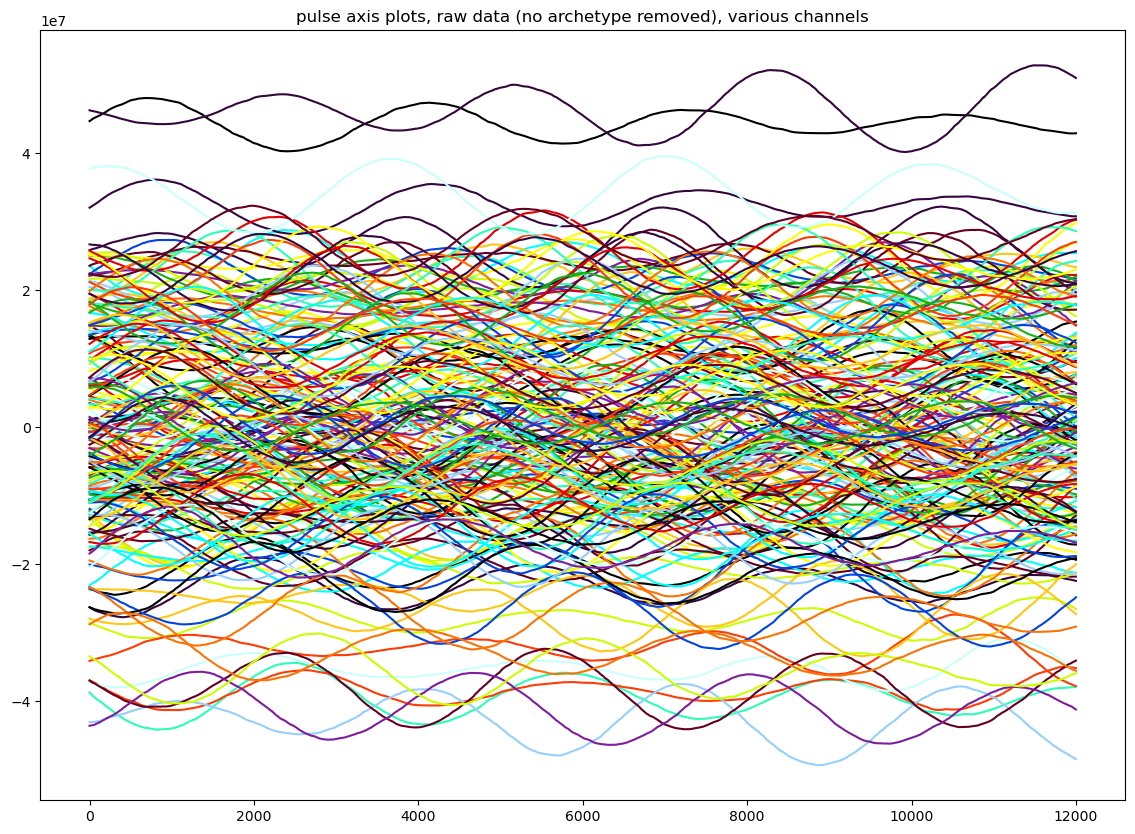

In [10]:
# set up a double chart
fig,ax=plt.subplots(figsize=(14,10))

# chart traces run along the pulse axis, several fixed channels, no archetype subtraction.

pulse0, pulseN          = 0, 12000           # Time separation (sec) = delta-pulse / 200
chan0, chanN, chanDelta = 12500, 13500, 5    # Channel range x 2 = seismometer span (m)

for chan in range(chan0, chanN + 1, chanDelta):
    j = (chan - chan0) // chanDelta
    ax.plot(a[pulse0:pulseN, chan], c=colors[j%ncolors])
    
ax.set(title='pulse axis plots, raw data (no archetype removed), various channels')

fig.show()

In [11]:
# 'archetype' reflects the stationary random nature of cable reflections.
# The idea is to calculate the mean of each channel along the pulse axis
#   and subtract that from the raw data into a 2D array 'g'.

mean_archetype=np.mean(a,axis=0)
g=np.zeros((dlen, dwid))
for i in range(dlen): g[i] = a[i] - mean_archetype[:]

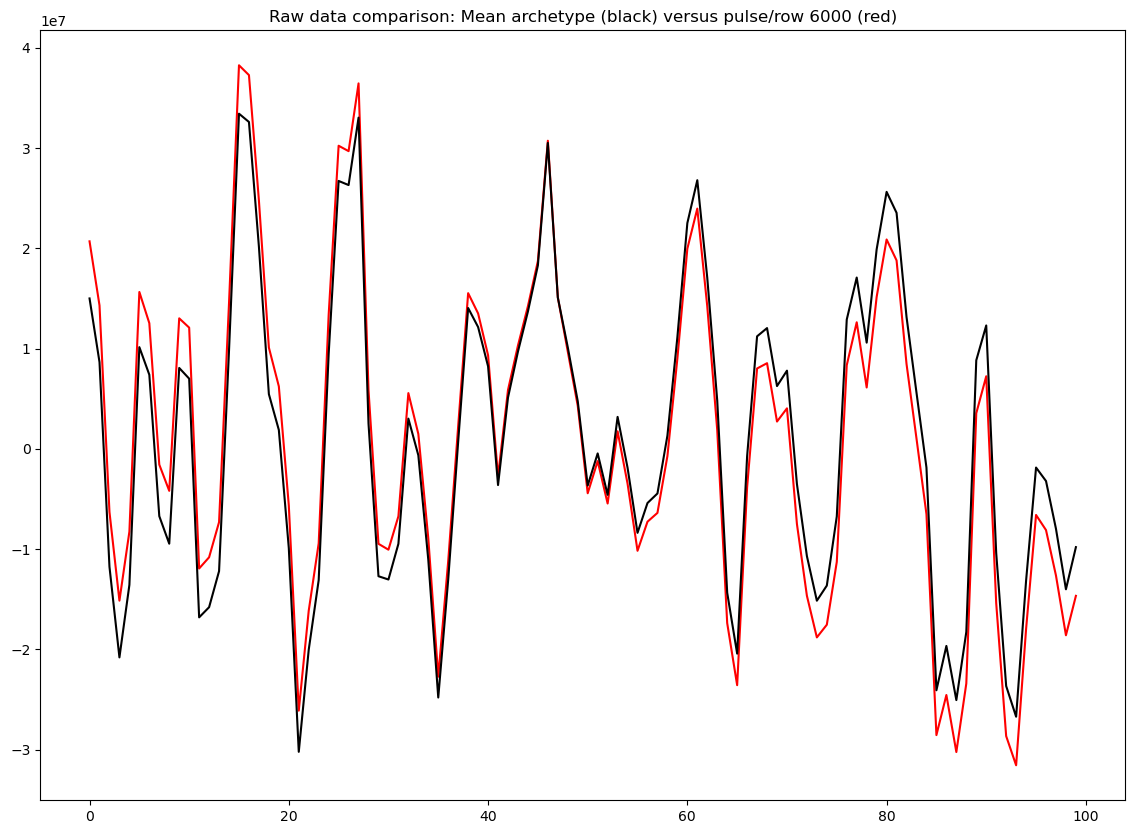

In [12]:
fig,ax=plt.subplots(figsize=(14,10))
c0 = 10000
c1 = 10100
ax.plot(a[6000, c0:c1], c = 'r')
ax.plot(mean_archetype[c0:c1], c = 'k')
ax.set(title = 'Raw data comparison: Mean archetype (black) versus pulse/row 6000 (red)')
fig.show()

In [13]:
print('raw data less archetype structure:')
print(g.size)
print(g.ndim)
print(g.shape)
print(type(g[0]))
print(type(g[0,0]))

raw data less archetype structure:
240000000
2
(12000, 20000)
<class 'numpy.ndarray'>
<class 'numpy.float64'>


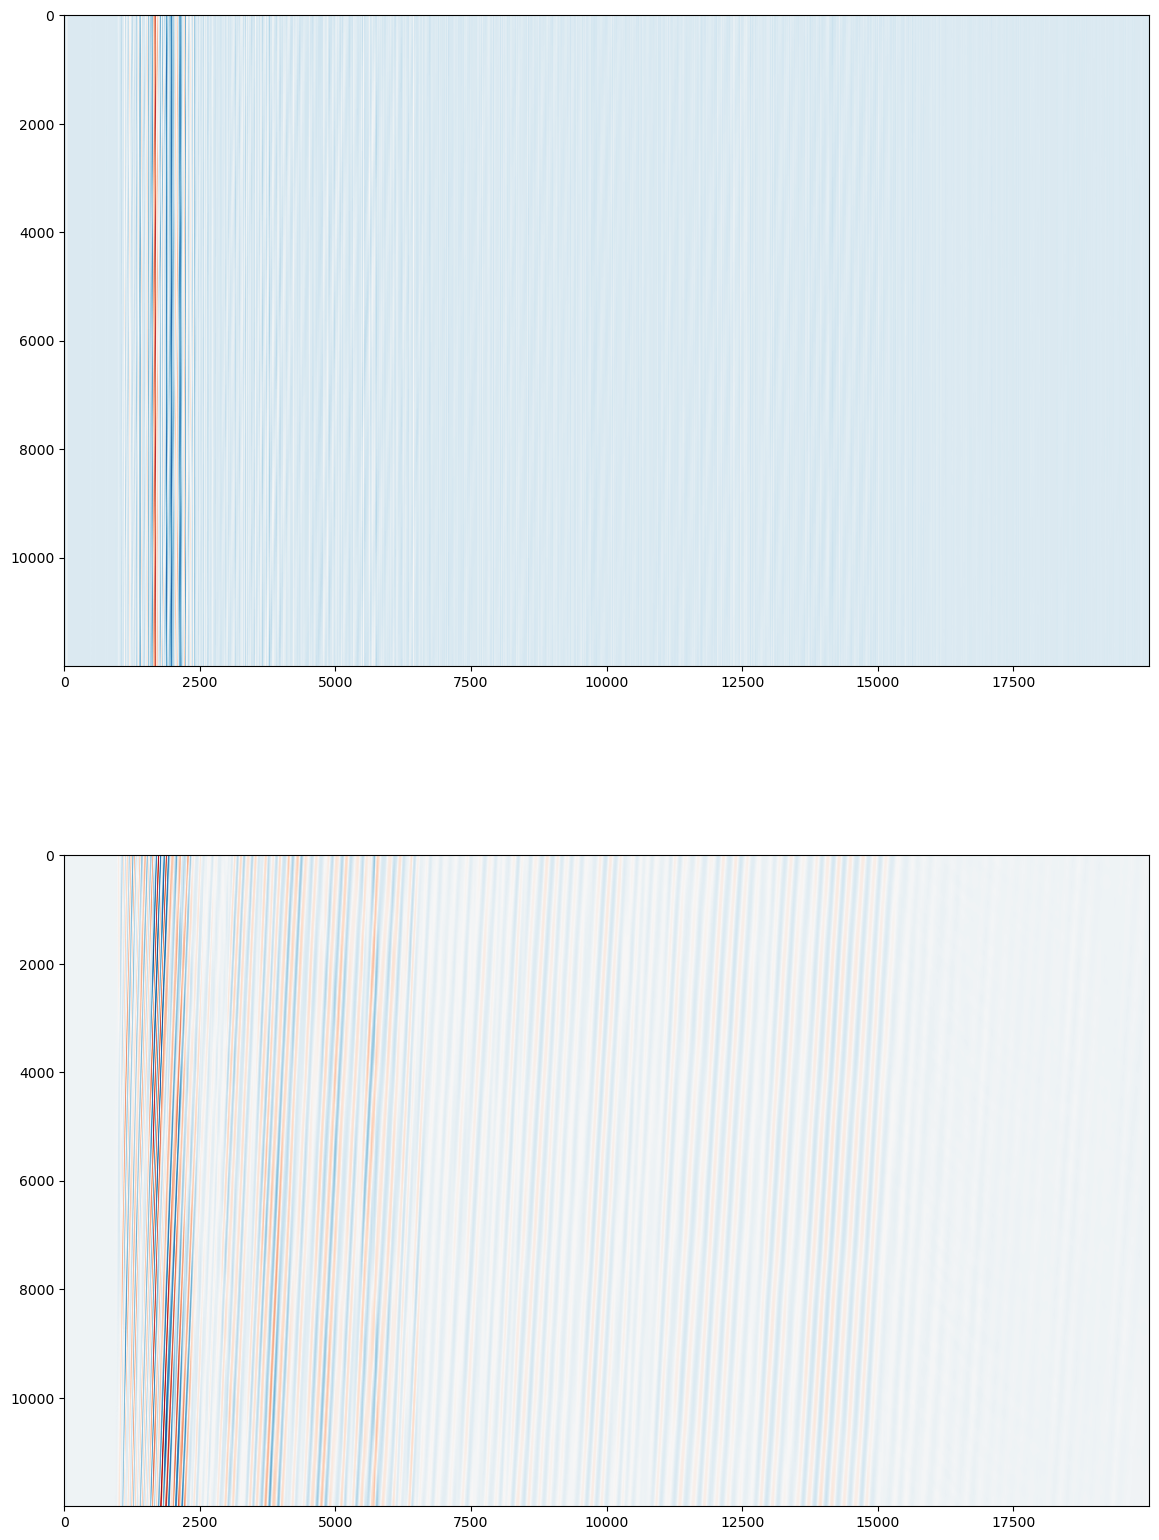

In [29]:
fig,ax=plt.subplots(2,figsize=(14,20))
ax[0].imshow(a, cmap='RdBu')
ax[1].imshow(g, cmap='RdBu')
fig.show()

In [15]:
g_fft2d = np.fft.fft2(g)

In [16]:
print()
print('FFT 2D (G)')
print(g_fft2d.size)
print(g_fft2d.ndim)
print(g_fft2d.shape)
print(type(g_fft2d[0]))
print(type(g_fft2d[0,0]))


FFT 2D (G)
240000000
2
(12000, 20000)
<class 'numpy.ndarray'>
<class 'numpy.complex128'>


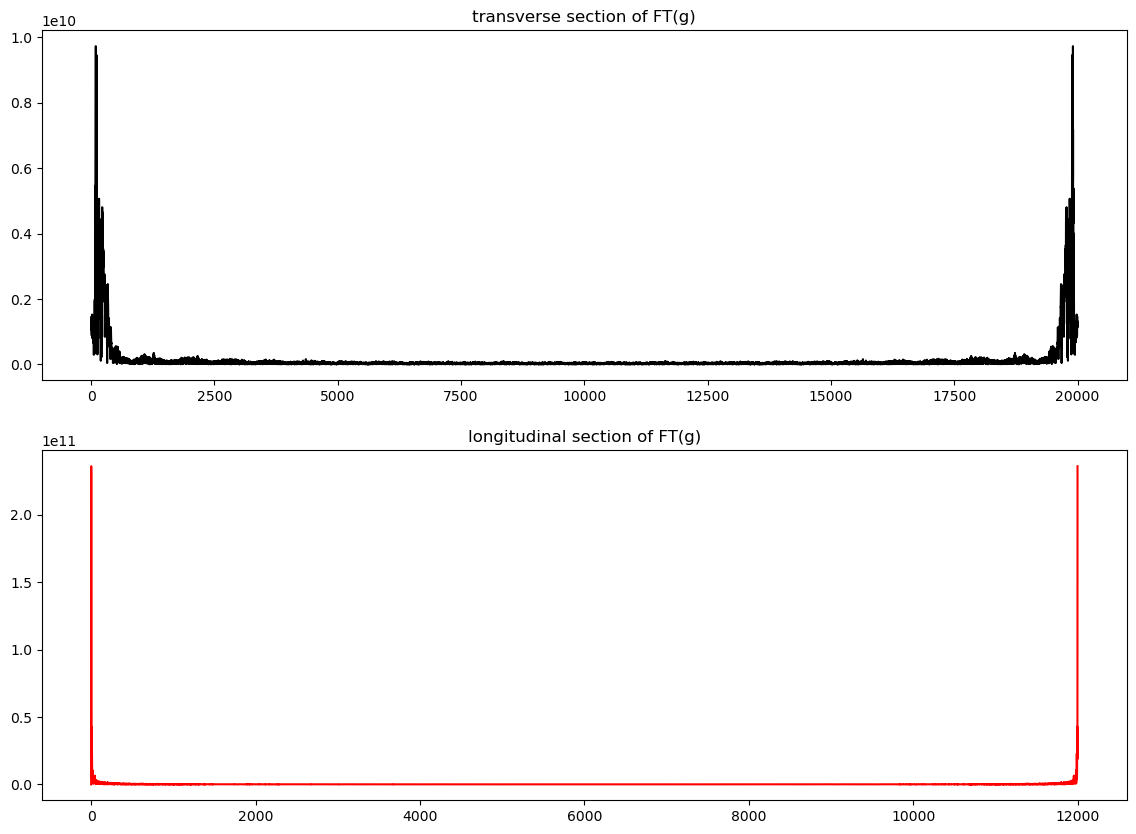

In [17]:
fig,ax=plt.subplots(2, figsize=(14,10))
ax[0].plot(np.abs(g_fft2d[6000]), c='k')
ax[0].set(title='transverse section of FT(g)')
ax[1].plot(np.abs(g_fft2d[:,10000]), c='r')
ax[1].set(title='longitudinal section of FT(g)')
fig.show()

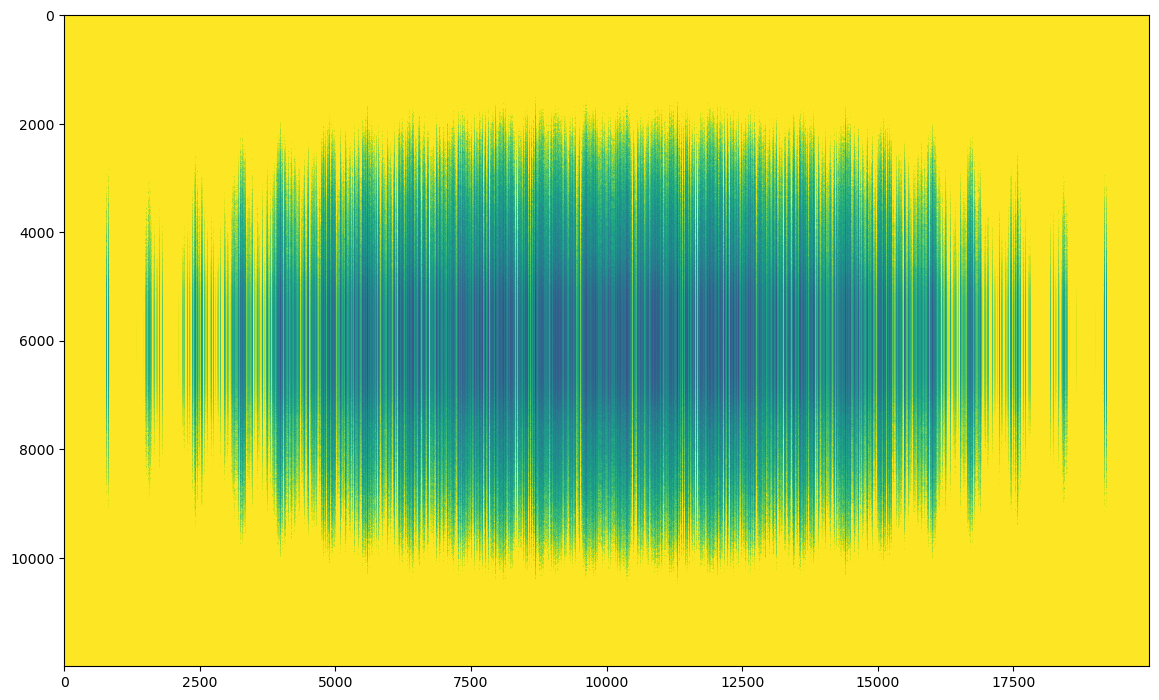

In [18]:
fig,ax=plt.subplots(figsize=(14,10))
ax.imshow(np.abs(g_fft2d), cmap='viridis', vmin=0.00, vmax=7e7)
fig.show()

In [19]:
mask=np.ones((dlen, dwid))
sigma_c   = 4000.
sigma_p   = 1000.
sc_denom  = 1./(2.*sigma_c**2)          # sigma channel denominator
sp_denom  = 1./(2.*sigma_p**2)          # sigma pulse denominator
wid_half  = dwid // 2
len_half  = dlen // 2
arglim    = -20.
absarglim = np.abs(arglim)
len_mod   = dlen//10

# for j in range(dlen):
    # if not j % len_mod: print(j)
    # y = j if j < len_half else j - dlen
    # y_arg = sp_denom*(y**2)
    # if y_arg < absarglim:
        # for i in range(dwid):
            # x = i if i < wid_half else i - dwid
            # arg = -(sc_denom*x**2 + y_arg)
            # if arg > arglim: mask[j, i] = 1 - np.exp(arg)

In [ ]:
fig,ax=plt.subplots(figsize=(14,10))
ax.imshow(mask, cmap='viridis')
fig.show()

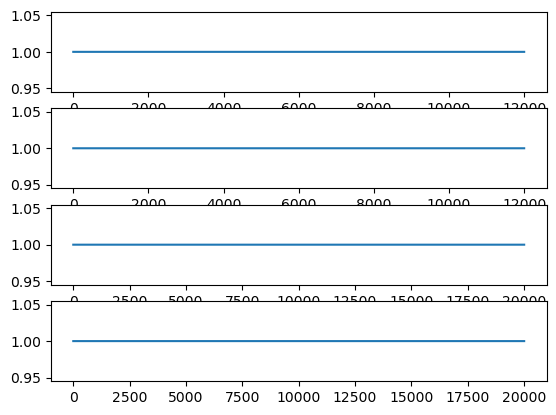

In [20]:
fig,ax=plt.subplots(4)
ax[0].plot(mask[:,0])
ax[1].plot(mask[:,dwid-1])
ax[2].plot(mask[0])
ax[3].plot(mask[dlen-1])
fig.show()

In [21]:
g_fft2d_masked = np.multiply(g_fft2d, mask)

In [22]:
print()
print('FFT(g), with mask applied')
print(g_fft2d_masked.size)
print(g_fft2d_masked.ndim)
print(g_fft2d_masked.shape)
print(type(g_fft2d_masked[0]))
print(type(g_fft2d_masked[0,0]))


FFT(g), with mask applied
240000000
2
(12000, 20000)
<class 'numpy.ndarray'>
<class 'numpy.complex128'>


In [23]:
g_hpf = np.abs(np.fft.ifft2(g_fft2d_masked))

In [24]:
print()
print('g_hpf is the absolute value of the high-pass filter of g')
print(g_hpf.size)
print(g_hpf.ndim)
print(g_hpf.shape)
print(type(g_hpf[0]))
print(type(g_hpf[0,0]))


g_hpf is the absolute value of the high-pass filter of g
240000000
2
(12000, 20000)
<class 'numpy.ndarray'>
<class 'numpy.float64'>


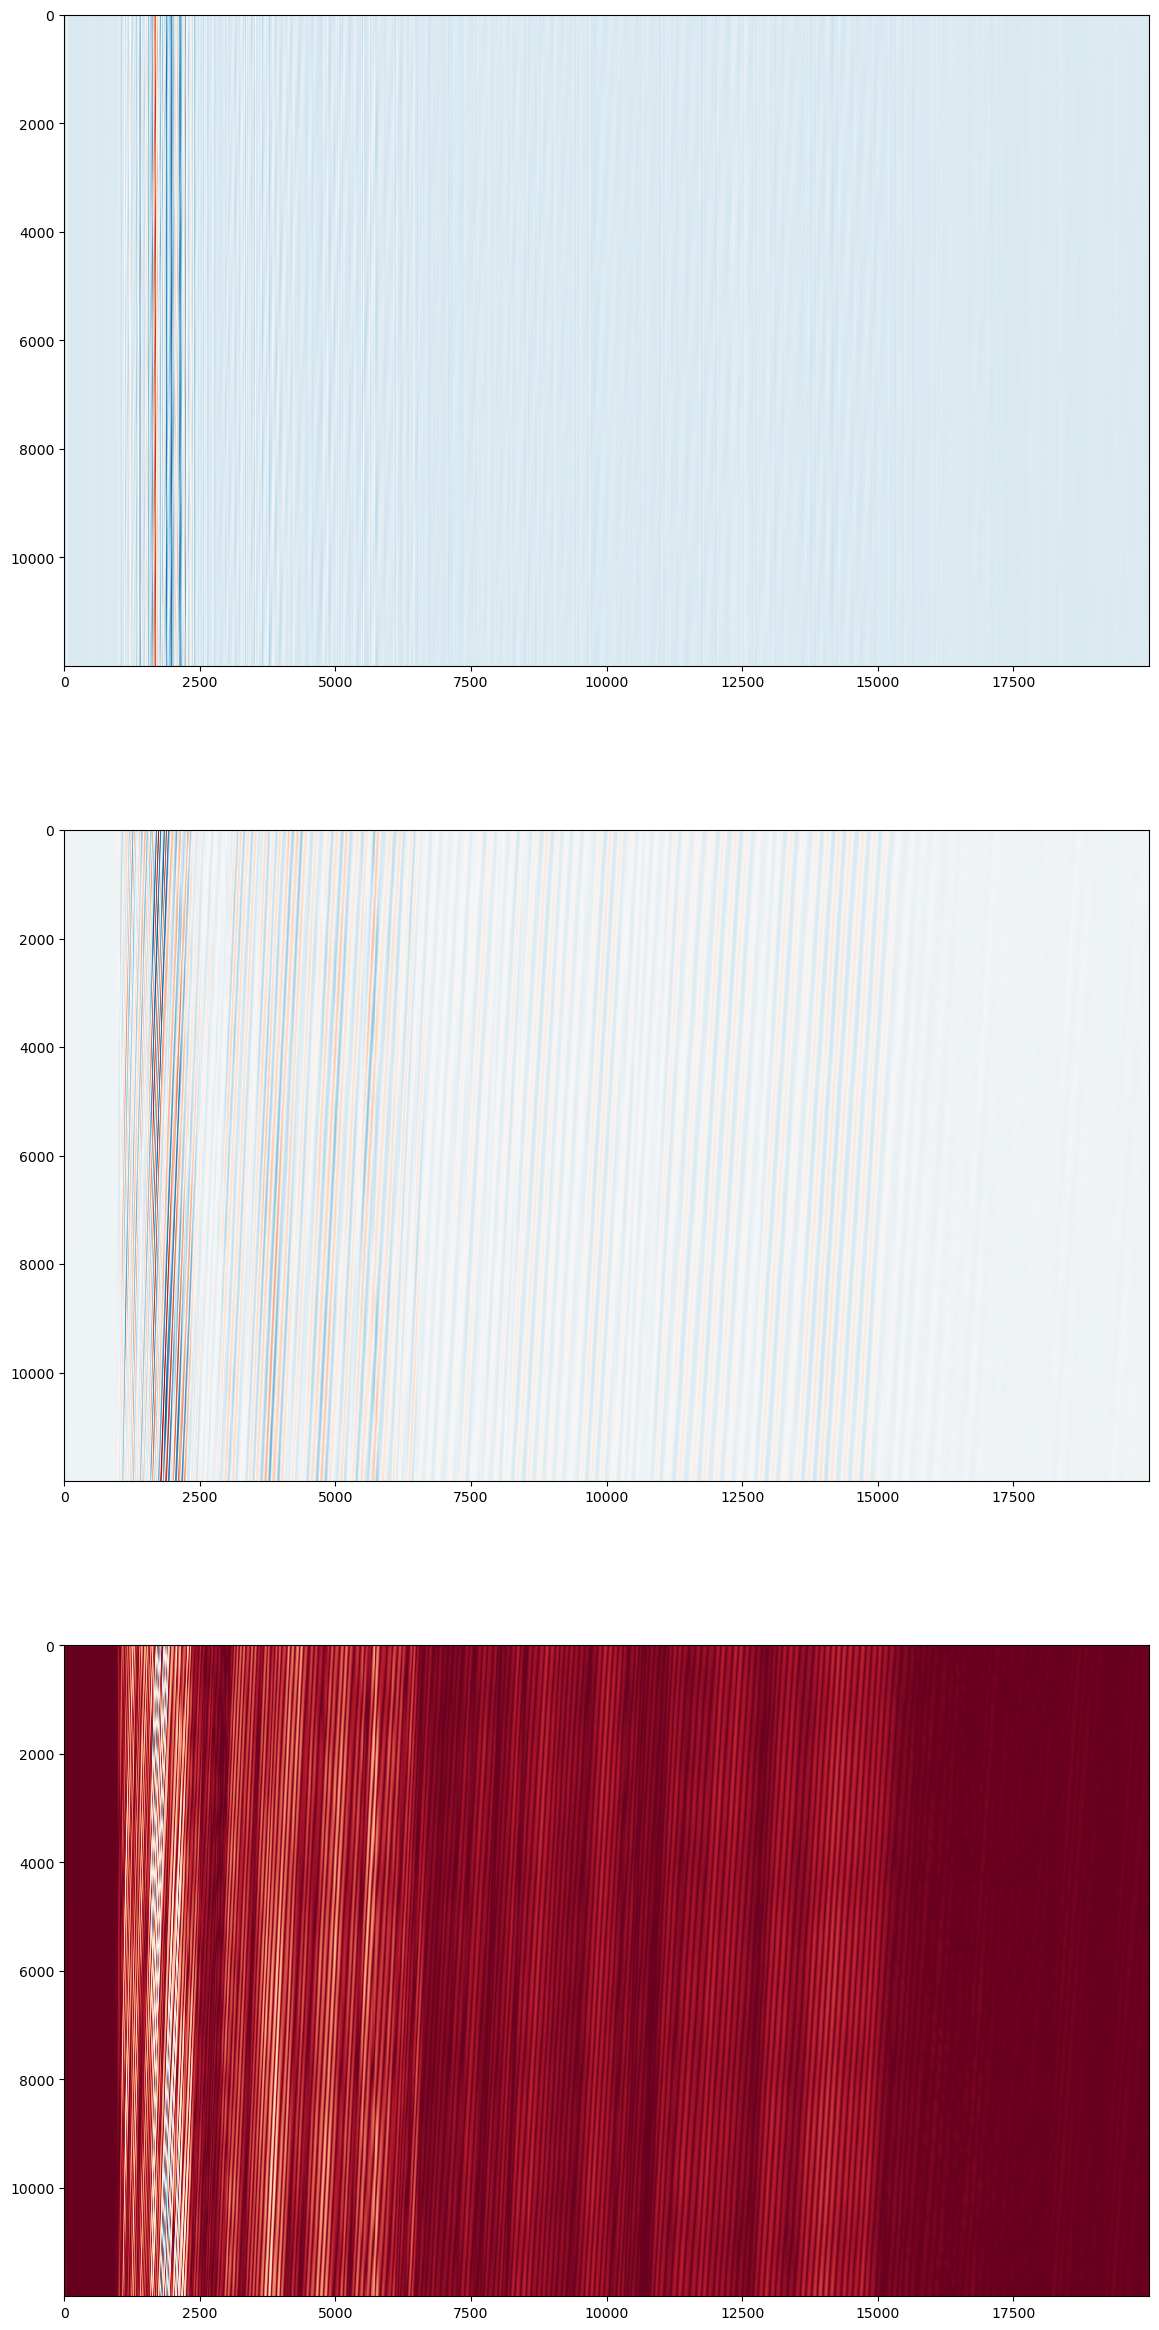

In [30]:
fig,ax=plt.subplots(3,figsize=(14,30))
ax[0].imshow(a, cmap='RdBu')
ax[1].imshow(g, cmap='RdBu')
ax[2].imshow(g_hpf, cmap='RdBu')         # , vmin=0., vmax=100000.)
fig.show()

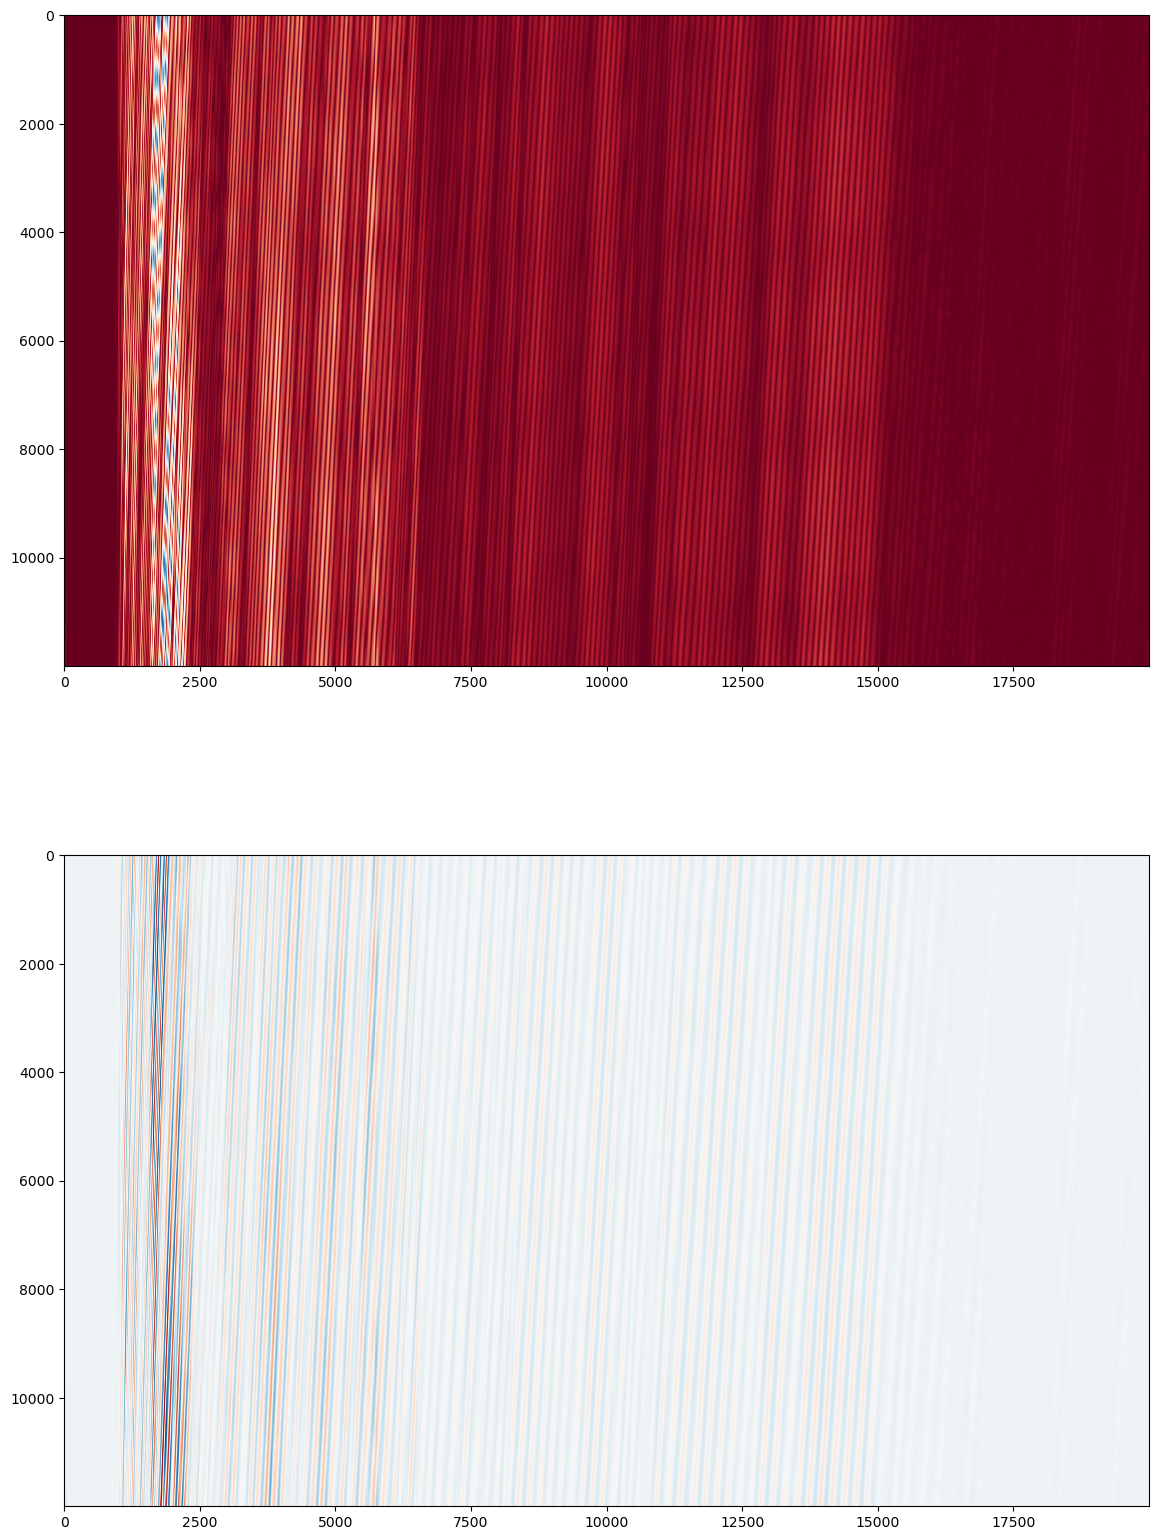

In [32]:
fig,ax=plt.subplots(2,figsize=(14,20))
ax[0].imshow(g_hpf, cmap='RdBu')         # , vmin=0., vmax=100000.)
ax[1].imshow(    g, cmap='RdBu')
fig.show()

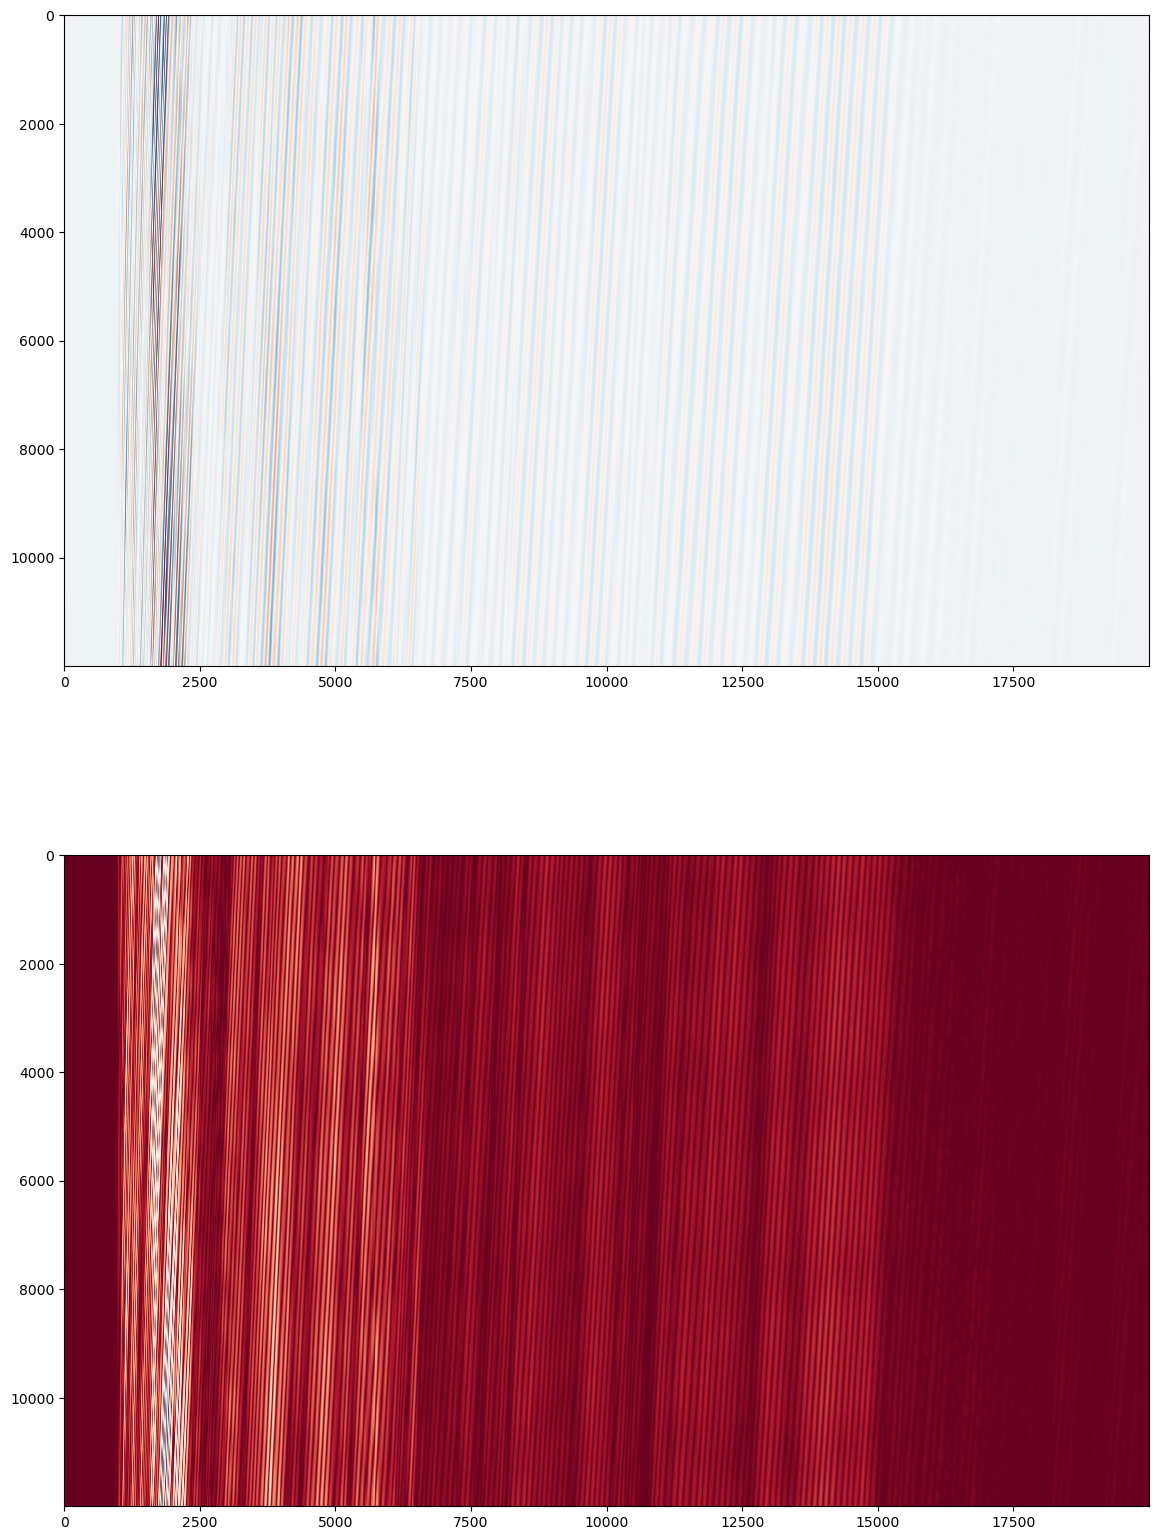

In [33]:
fig,ax=plt.subplots(2,figsize=(14,20))
ax[0].imshow(    g, cmap='RdBu')
ax[1].imshow(g_hpf, cmap='RdBu')         # , vmin=0., vmax=100000.)
fig.show()

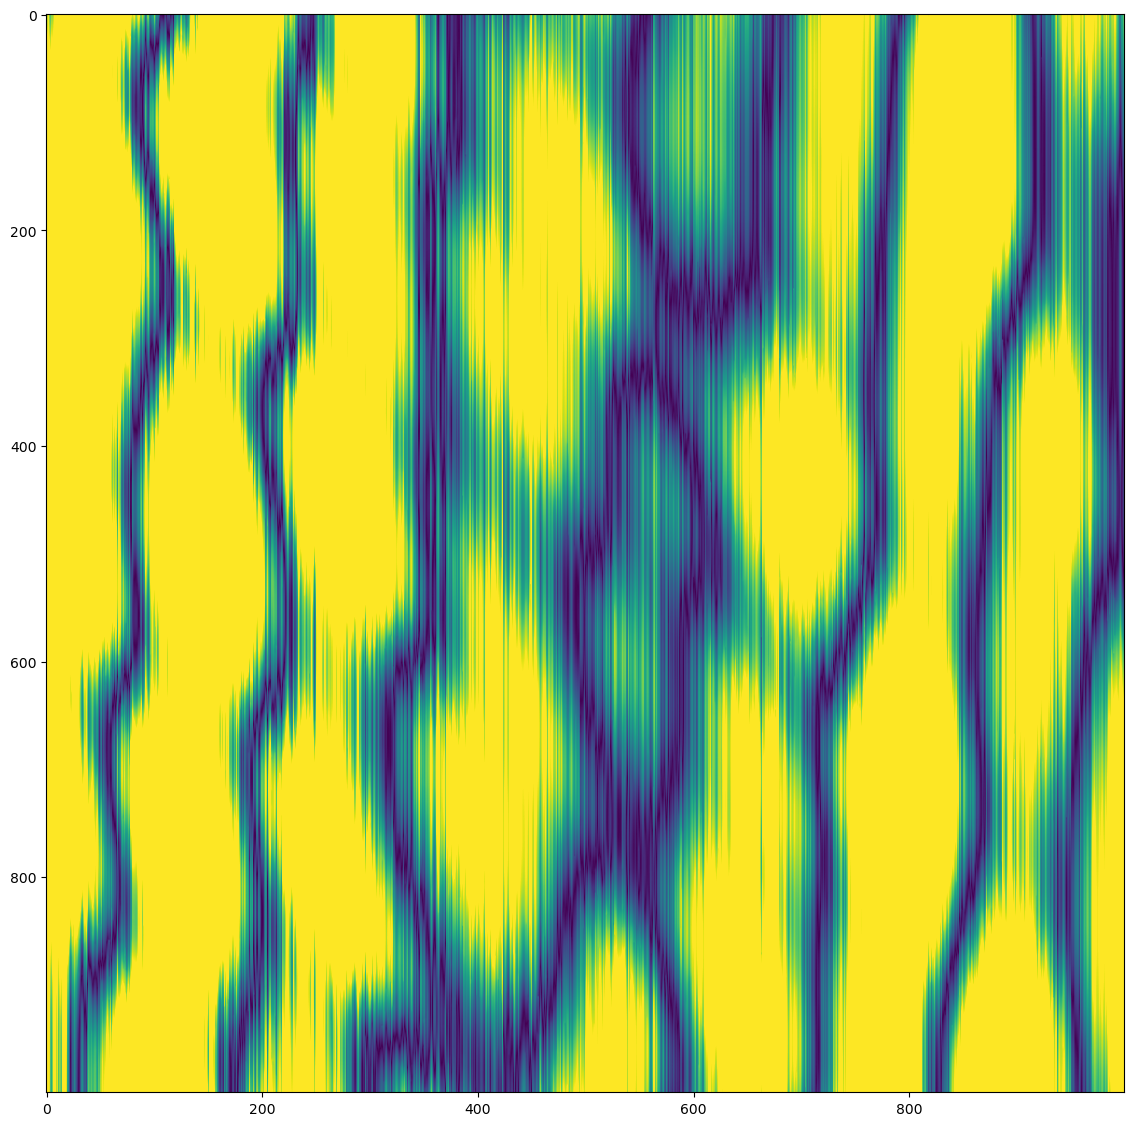

In [27]:
p0, p1 =  7000,  8000
c0, c1 = 16000, 17000
fig,ax=plt.subplots(figsize=(14,14))
ax.imshow(g_hpf[p0:p1, c0:c1], cmap='viridis', vmin=0., vmax=500000.)
fig.show()

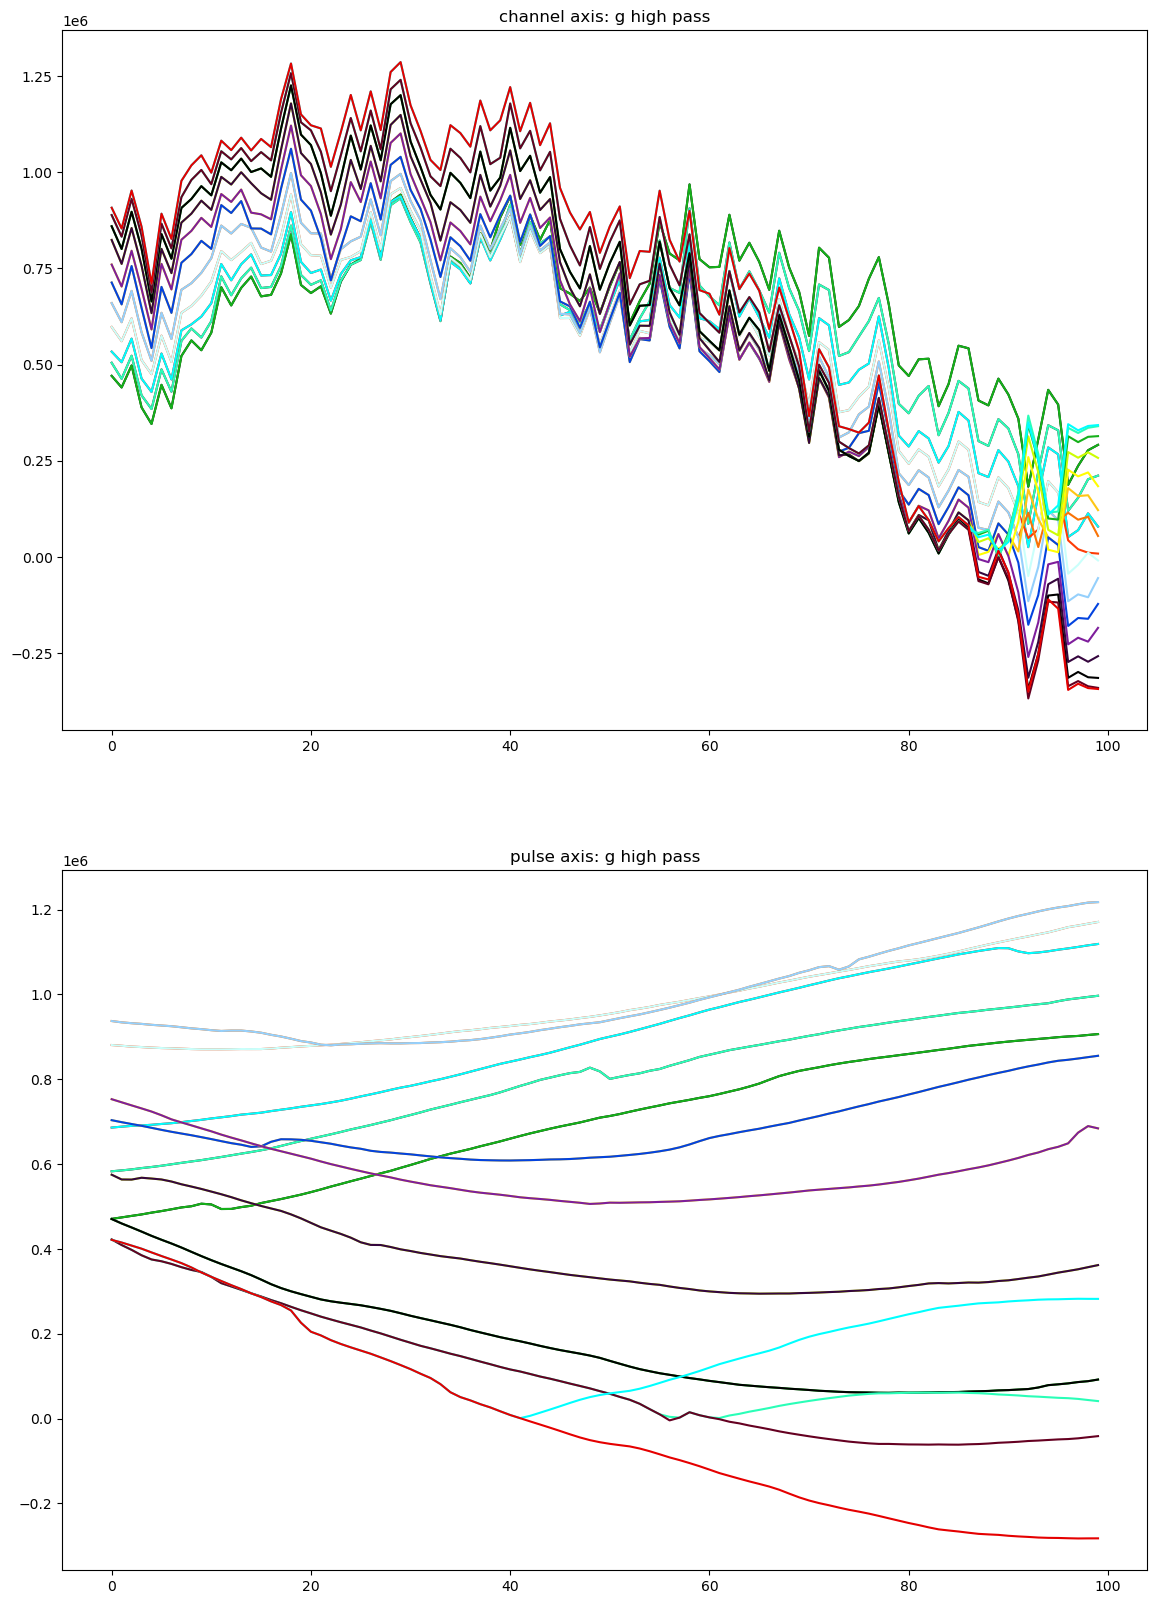

In [28]:
# double chart: top is along the channel axis, bottom along the pulse axis
#   - data in g_hpf[row, col]

fig,ax=plt.subplots(2,figsize=(14,20))

p0, p1, dp =  7000,  7100, 10
c0, c1, dc = 16000, 16100, 10

for i in range(p0, p1 + 1, dp):
    j = (i - p0)//dp
    ax[0].plot(g_hpf[i, c0:c1], c=colors[j%ncolors])
    ax[0].plot(    g[i, c0:c1], c=colors[(j+8)%ncolors])

for i in range(c0, c1 + 1, dc):
    j = (i - c0)//dc
    ax[1].plot(g_hpf[p0:p1, i], c=colors[j%ncolors])
    ax[1].plot(    g[p0:p1, i], c=colors[(j+8)%ncolors])

ax[0].set(title='channel axis: g high pass')
ax[1].set(title='pulse axis: g high pass')

fig.show()

#### Results so far


The masked HPF uses two gaussians but the results are not convincing. Current state of
the code uses a unity mask so the result should match the original but it does not. 
The chart above tries to compare various transects but it is not vertically offset so
it is hard to tell what is matching and what is departure. 


Generally the objective I am trying to chase these down: Proper form and scale 
of a high pass filter that washes out the wave action while leaving only
smoking gun high frequency signals. In the channel axis then waves are tens of 
channels long. In the pulse axis 400 samples and more.


Beyond that clearly the cable moves offshore and into progressively deeper water so
there is a progression of regimes in the channel axis. It would not hurt to look up 
the bathymetry etcetera.